# Efficient Cavity Control with SNAP Gates

This tutorial reproduces part of [Thomas Fösel et al. (2020)](https://arxiv.org/abs/2004.14256),
titled **Efficient cavity control with SNAP gates**. The general 
idea is to start in an initial state and apply a sequence of
operators to reach the desired target state.

In the paper, the authors use a vacuum state, $|0 \rangle$,
with a Hilbert space cutoff of 10. 

Authors apply sequence of operators as blocks, $\hat{B}$,
where 

\begin{equation}
\hat B = D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger}
\end{equation}


In the equation above, $D(\alpha)$ is a Displace operation
given by 

\begin{equation}
D(\alpha) = e^{\alpha a^{\dagger} - \alpha^* \hat a}
\end{equation} 


where $\alpha$ is the complex displacement parameter, 
and $a^{\dagger}$ and $\hat a$ are the bosonic creation
and annihilation operators respectively.

$S(\vec \theta)$ in the block definition of $\hat{B}$
above is the selective number-dependent-snap arbitrary
phase (SNAP) gate defined as 

\begin{equation}\label{snap-gate}
\hat S(\vec{\theta}) = \sum_{0}^{n} e^{i \theta^{(n)}} |n\rangle \langle n|
\end{equation}

where $\vec{\theta}$ is the real vector containing SNAP
parameters, and $|n\rangle$ is the number state.


With the operator definitions laid out, the idea now is to 
apply this sequence of $D(\alpha)$, $S(\vec{\theta})$, and
$D(\alpha)^{\dagger}$ operations to $|0 \rangle$, in order
to reach the target binomial state, which in this case is

\begin{equation}
b_{1} = \frac{\sqrt 3 |3\rangle + |9\rangle}{2}
\end{equation}

**Note:** We do not follow the _exact_ same scheme as used in
[Thomas Fösel et al. (2020)](https://arxiv.org/abs/2004.14256),
in that we use a simpler cost function (without regularization)
and do not add blocks in a Breadth-First manner.

In [1]:
import numpy as onp # this is ordinary numpy that we will
                    # use with QuTiP for visualization only.
                    # onp should not used for gradient 
                    # calculations. Instead jax.numpy
                    # should be used. 

import jax.numpy as jnp
from jax import grad, jit
from jax.experimental import optimizers

# Visualization
import matplotlib.pyplot as plt
from qutip.visualization import plot_wigner, hinton
from qutip import Qobj # imported purely for visualization purposes due to QuTiP-JAX non-compatibility

from qgrad.qgrad_qutip import basis, to_dm, dag, Displace, fidelity

from tqdm.auto import tqdm

In [2]:
def pad_thetas(hilbert_size, thetas):
    """
    Pads zeros to the end of a theta vector to 
    fill it upto the Hilbert space cutoff.
    
    Args:
        hilbert_size (int): Size of the hilbert space
        thetas (:obj:`jnp.ndarray`): List of angles thetas
    
    Returns:
        :obj:`jnp.ndarray`: List of angles padded with zeros 
        in place of Hilbert space cutoff

    """
    if len(thetas) != hilbert_size:
        thetas = jnp.pad(thetas, (0, hilbert_size - len(thetas)), mode="constant")
    return thetas

def snap(hilbert_size, thetas):
    """
    Constructs the matrix for a SNAP gate operation
    that can be applied to a state.
    
    Args:
        hilbert_size (int): Hilbert space cuttoff
        thetas (:obj:`jnp.ndarray`): A vector of theta values to 
                apply SNAP operation
    
    Returns:
        :obj:`jnp.ndarray`: matrix representing the SNAP gate
    """
    op = 0 * jnp.eye(hilbert_size)
    for i, theta in enumerate(thetas):
        op += jnp.exp(1j * theta) * to_dm(basis(hilbert_size, i))
    return op

## Insertion of Blocks

$T$ number of displace-snap-displace blocks, 
$\hat B = D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger}$
are applied on the initial vacuum state, $|0 \rangle$

In this reconstruction we choose $T = 3$, so $3$
$\hat B$'s are applied to the initial state. The 
aim is to tune $\alpha$'s and $\vec{\theta}$'s
such that three repeated applications of 
$\hat B$ on $|0 \rangle$ 

\begin{equation}
D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger}
D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger} 
D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger} |0 \rangle
\end{equation}

lead to the desired 
binomial state $b_{1}$
         
**Note on Displace operator**: We provide a fast implementation 
of the displacement operation using a diagonal decomposition 
such that a `Displace` class initialises the operator which 
can then be applied for different $\alpha$ repeatedly. This 
construct also supports autodiff with JAX.

In [3]:
def apply_blocks(alphas, thetas, initial_state):
    """Applies blocks of displace-snap-displace 
       operators to the initial state.
    
    Args:
        alphas (list): list of alpha paramters
                for the Displace operation
        thetas (list): vector of thetas for the
                SNAP operation
        initial_state(:obj:`jnp.array`): initial
                state to apply the blocks on
                
    Returns:
        :obj:`jnp.array`: evolved state after 
                applying T blocks to the initial
                state
    
    """

    if len(alphas) != len(thetas):
        raise ValueError("The number of alphas and theta vectors should be same")

    N = initial_state.shape[0]
    displace = Displace(N)
    x = initial_state

    for t in range(len(alphas)):
        x = jnp.dot(displace(alphas[t]), x)
        x = jnp.dot(snap(N, thetas[t]), x)
        x = jnp.dot(displace(-alphas[t]), x) # displace(alpha)^{\dagger} = displace(-alpha)
    return x

## Visualizing the state evolution under $\hat B$

Before we move on to make learning routines, it might be a
good idea to see what `apply_blocks` does to the initial 
state, $|0 \rangle$ with randomly initialized parameters
$\alpha$ and $\vec{\theta}$

/home/asad/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


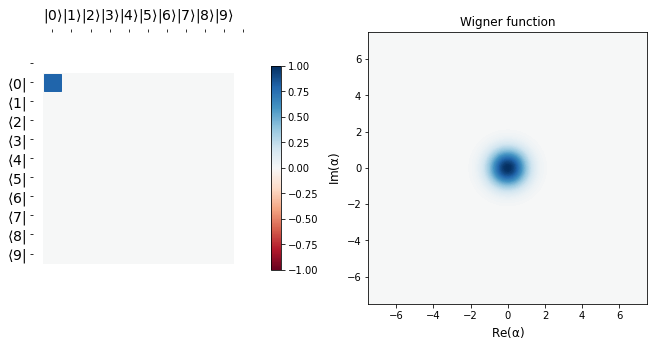

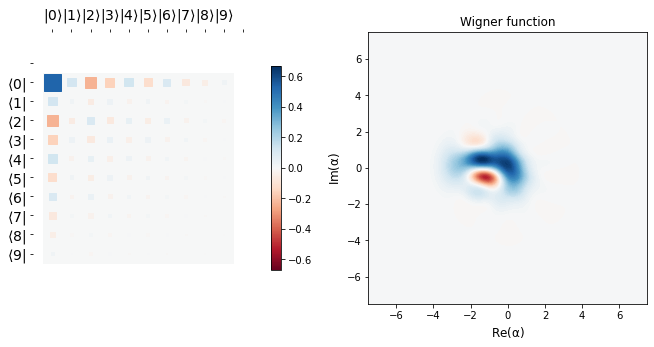

In [4]:
def show_state(state):
    """Shows the Hinton plot and Wigner function for the state"""
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    if state.shape[1] == 1: # State is a ket
        dm = Qobj(onp.array(jnp.dot(state, dag(state))))
        hinton(dm, ax=ax[0])
        plot_wigner(dm, ax=ax[1])
    plt.show()
    
N = 10 # Hilbert space cutoff

initial_state = basis(N, 0) # initial vacuum state
show_state(initial_state)

alphas = jnp.array([1., 0.5, 1.]) # Displace parameters

theta1, theta2, theta3 = [0.5], [0.5, 1.5, 0.5], [0.5, 1.5, 0.5, 1.3] # SNAP parameters
# NOTE: No input values to JAX differentiable functions should be int
thetas = jnp.array([pad_thetas(N, p) for p in [theta1, theta2, theta3]])

evolved_state = apply_blocks(alphas, thetas, initial_state)
show_state(evolved_state)

The target state that we aim to reach is visualized below. 
The aim is to act `apply_blocks` function to the initial 
state with the optimized parameters, say $\alpha_{opt}$
and $\theta_{opt}$ such that we land extremely close to the
desired binomial state $b_{1}$ as defined above.

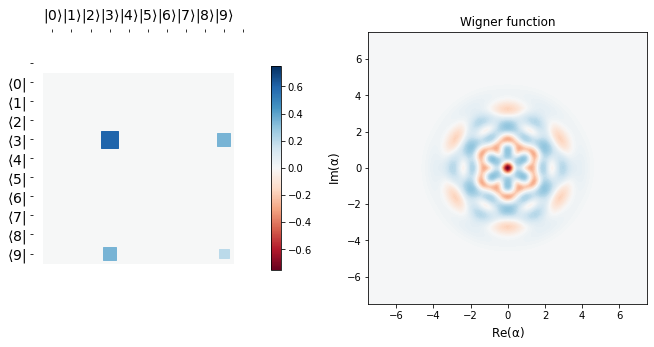

In [5]:
target_state = (jnp.sqrt(3) * basis(N, 3) +  basis(N, 9)) / 2.0 # target state b1 as shown above|
show_state(target_state)

In [6]:
def cost(params, initial, target):
    """
    Calculates the cost between the target state and 
    the one evolved by the action of three blocks.
    
    Args:
    -----
        params (jnp.array): alpha and theta params of Displace and SNAP respectively
        initial (jnp.array): initial state to apply the blocks on
        target (jnp.array): desired state
    
    Returns:
    --------
        cost (float): cost at a particular parameter vector
    """
    alphas, thetas = params[0], params[1]
    evo = apply_blocks(alphas, thetas, initial)
    return 1 - fidelity(target, evo)[0][0]

## Optimization using Adam -- case in point for `qgrad`

This is where the power of `qgrad` comes in. 
Since qgrad's functions used in this notebook -- basis,
to_dm, dag, Displace, fidelity -- support JAX, we can 
evaluate the gradient of the cost function in one line 
using JAX's `grad`. This saves us painstakingly evaluating 
the derivative of the cost function analytically.


In [7]:
alphas = jnp.array([1, 0.2, 0.1 - 1j]) # Displace parameters
theta1, theta2, theta3 = ([0.5],
                          [0., 0.5],
                          [0.1, 0., 0., 0.1])
# NOTE: No input values to JAX differentiable functions should be int
thetas = jnp.array([pad_thetas(N, p) for p in [theta1, theta2, theta3]])

init_params = [alphas, thetas]
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init([alphas, thetas])


def step(i, opt_state, opt_update):
    params = get_params(opt_state)
    g = grad(cost)(params, initial_state, target_state)
    return opt_update(i, g, opt_state)

epochs = 150
pbar = tqdm(range(epochs))

fidel_hist = []
params_hist = []

for i in pbar:
    opt_state = step(i, opt_state, opt_update)
    params = get_params(opt_state)
    params_hist.append(params)
    f = 1 - cost(params, initial_state, target_state)
    fidel_hist.append(f)
    pbar.set_description("Fidelity {}".format(f))

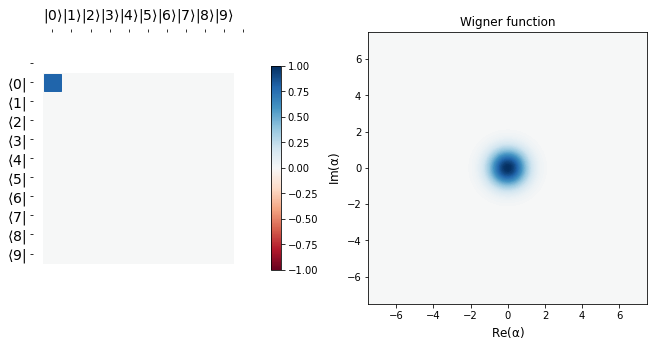

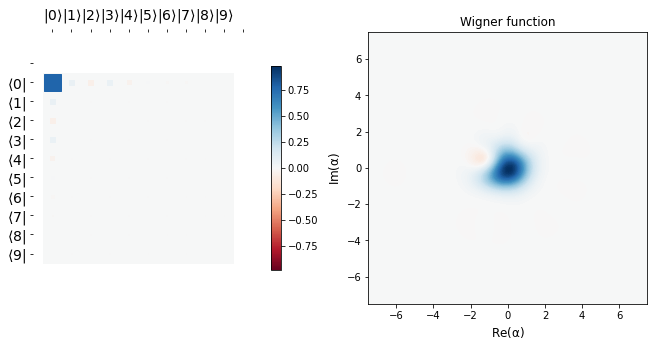

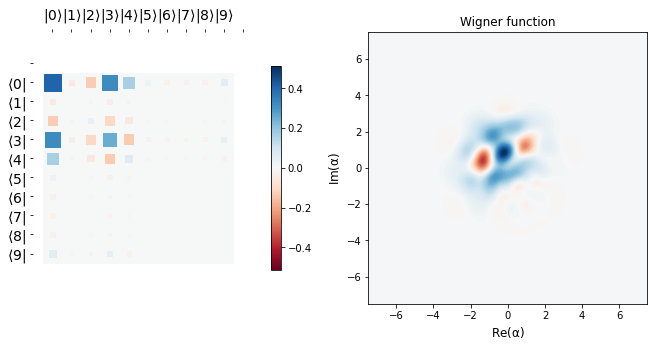

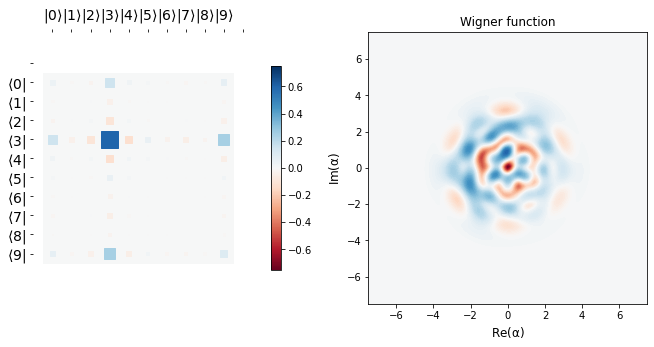

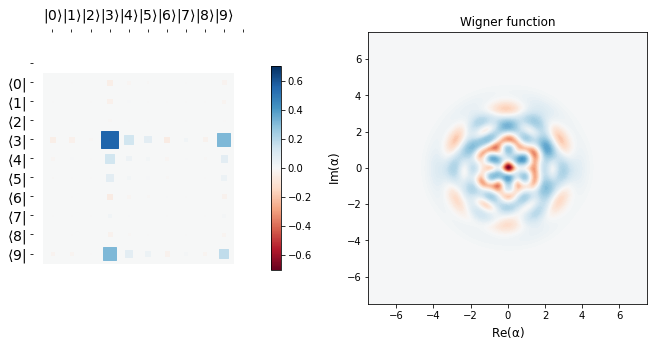

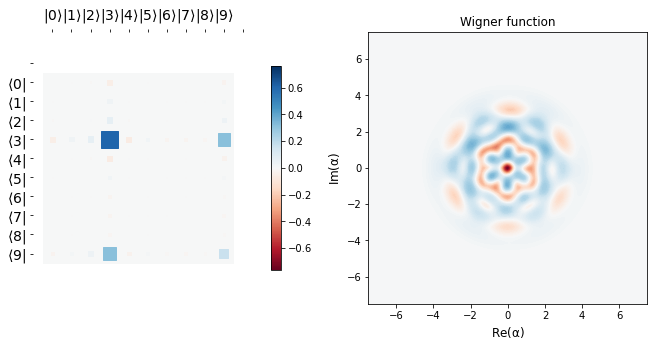

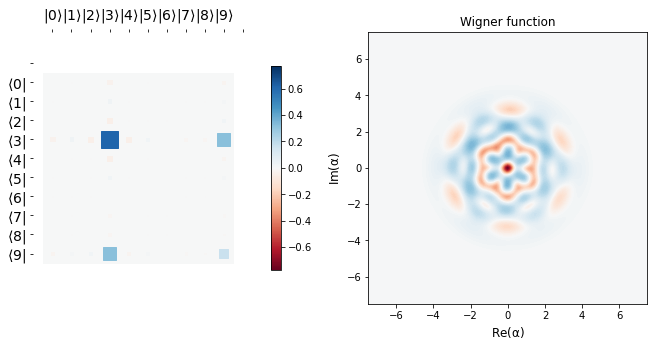

In [8]:
def display_evolution(parameters, num_plots = 4):
    """
    Displays the intermediate states during the learning schedule.
    
    Args:
        parameters (list): List of device arrays of parameters
            `alpha` and `theta`
        num_plots (int): Number of plots to make generate (except
            the initial and final state plots)
            
    Returns:
        Evolution of the state at `num_plots` equidistant
        times during the training
    """
    show_state(initial_state)
    
    diff = epochs // int(num_plots)
    for i in range(0, epochs, diff):
        alphas, thetas = parameters[i]
        x = apply_blocks(alphas, thetas, initial_state)
        show_state(x)
    
    # final parameters after last epoch
    alphas, thetas = parameters[-1]
    x = apply_blocks(alphas, thetas, initial_state)
    show_state(x)
    
display_evolution(params_hist)

## Conclusion

We see that starting from a vacuum state $|0 \rangle$, 
we efficiently learn the target state 
$b_{1} = \frac{\sqrt 3 |3> + |9>}{2}$, as is corroborated
by the fidelity plot below.

The desired target state's Hinton plot and Wigner function
are shown before the learning scedule starts. It can be 
seen that the last row above is _almost_ the same as the 
target state, implying we learn parameters $\alpha$ and 
$\vec \theta$ efficiently so as to go from the vacuum 
state to a desired target state in just **three** applications
of blocks, $\hat B$. This tutorial is just meant to show the 
usage of `qgrad`. Like the authors in the original paper, one
may use more sophistacated techniques like gradient clipping,
regularized cost function, and greater number of epochs to
achieve even better learning.


Text(0.5, 0, 'epochs')

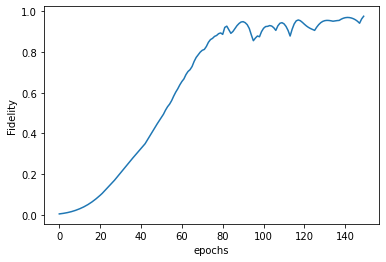

In [9]:
plt.plot(fidel_hist)
plt.ylabel("Fidelity")
plt.xlabel("epochs")

## References
[1] Fösel, Thomas, et al. "Efficient cavity control with SNAP gates." arXiv preprint arXiv:2004.14256 (2020).